In [2]:
using CairoMakie, LinearAlgebra, Dierckx, Optim

In [16]:
pars = (;α = 0.33, # Capital share
         β = 0.9, # Discount factor
         γ = 1.0, # CRRA parameter
         δ = 0.1, # Depreciation rate
         A = 2.0, # TFP
         θ = 3.0, # Expanding grid parameter
         grid_size = 101, # number of gridpoints
         grid_min = 0.75, # minimum gridpoint (multiple of steady state capital stock)
         grid_max = 1.25, # maximum gridpoint (multiple of steady state capital stock)
         lb = 0.7, # lower bound for optimisation
         ub = 1.3, # upper bound for optimisation
         maxiter = 10000, # maximum number of iterations
         toler = 1e-6) # tolerance

(α = 0.33, β = 0.9, γ = 1.0, δ = 0.1, A = 2.0, θ = 3.0, grid_size = 101, grid_min = 0.75, grid_max = 1.25, lb = 0.7, ub = 1.3, maxiter = 10000, toler = 1.0e-6)

In [17]:
function utility(c, pars)
    if pars.γ == 1
        return log(c)
    else
        return (c^(1-pars.γ))/(1-pars.γ)
    end
end

function production(k, kp, pars)
    (;A, α, δ) = pars
    return A*k^α + (1.0-δ)*k - kp
end

function exp_grid(pars)
    (; θ, grid_min, grid_max, grid_size, A, α, β, δ) = pars
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α)) 
    grid = LinRange(0, 1, grid_size)
    grid = grid_min*Kss .+ (grid_max*Kss .- grid_min*Kss).*grid.^θ
    return grid
end

function interpV(grid, v)
    return Spline1D(grid, v, k=3, bc="extrapolate")
end

function optimise(grid, interp_v, policy, pars)
    (; grid_size, lb, ub, β, A, α, δ) = pars
    v_new = zeros(grid_size)
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α))
    for i in 1:grid_size
        obj(kp) = - (utility(A*grid[i]^α + (1.0-δ)*grid[i] - kp, pars) + β * interp_v(kp))
        res = optimize(obj,Kss*lb,Kss*ub)
        policy[i] = res.minimizer
        v_new[i] = -res.minimum
    end
    return v_new, policy
end

optimise (generic function with 1 method)

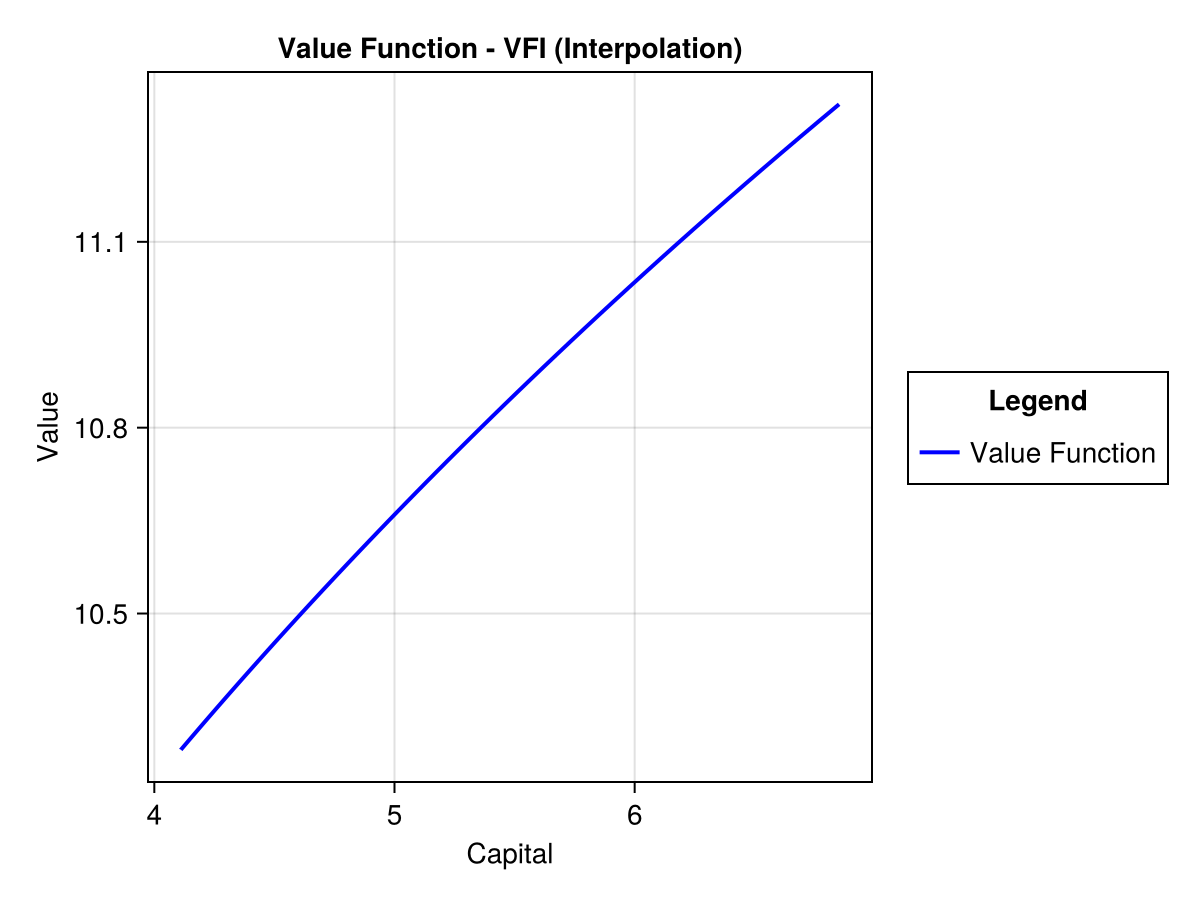

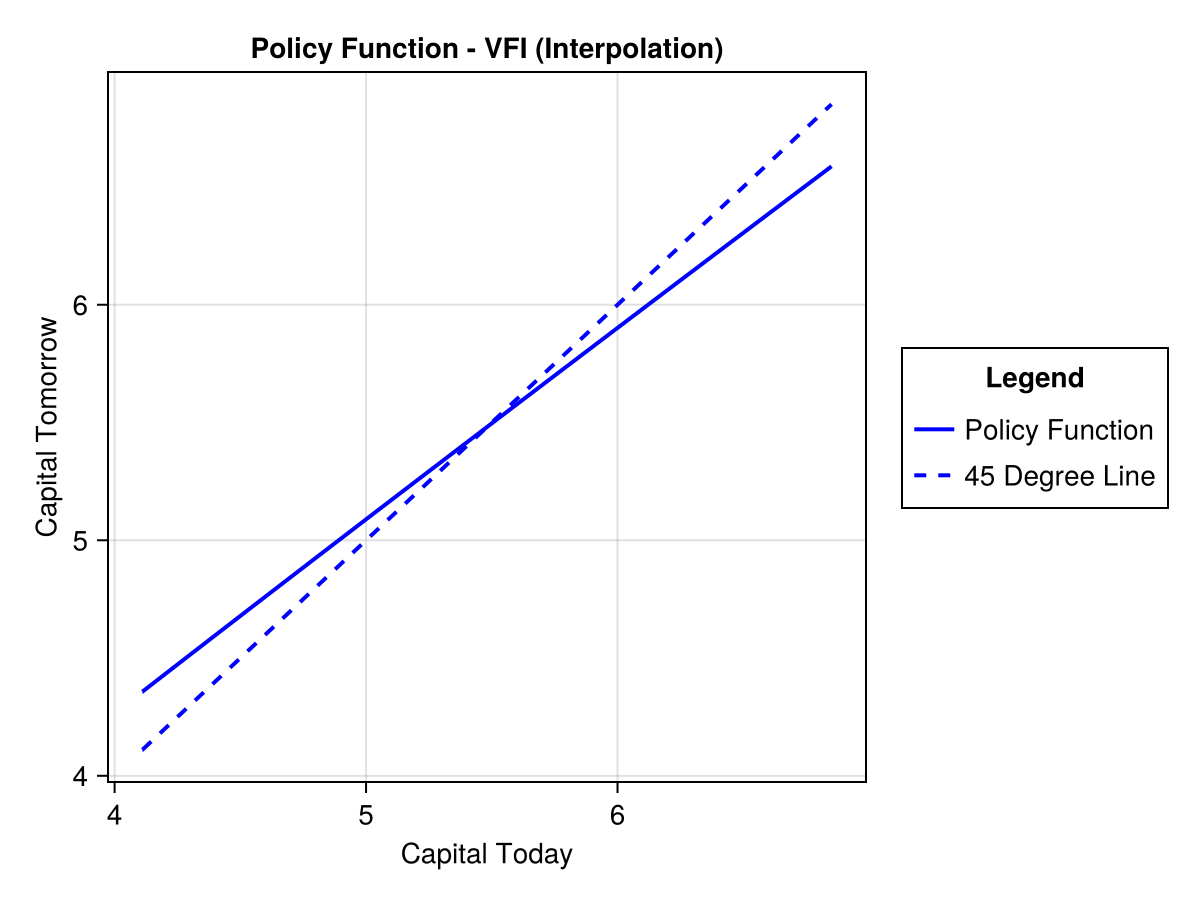

(Float32[10.280136, 10.280138, 10.280147, 10.28017, 10.280216, 10.2802925, 10.280407, 10.280566, 10.280777, 10.281049  …  11.096394, 11.12014, 11.144225, 11.168646, 11.193399, 11.218483, 11.243893, 11.269626, 11.295679, 11.322049], Float32[4.357293, 4.3572955, 4.3573112, 4.3573546, 4.3574386, 4.3575773, 4.357784, 4.3580723, 4.358456, 4.358949  …  6.0438046, 6.099364, 6.1561112, 6.214059, 6.2732186, 6.333602, 6.3952208, 6.4580874, 6.5222135, 6.587611])

In [18]:
function vfi(v, pars)
    (; α, β, δ, grid_size, maxiter, toler, A) = pars
    v_init = ones(grid_size)
    v_new = similar(v)
    policy = similar(v)
    K = exp_grid(pars)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v = interpV(K, v_init)
        v_new, policy = optimise(K, v, policy, pars)
        error = maximum(abs.(v_new - v_init))
        v_init .= v_new
        if iter % 100 == 0
            println("---------------------")
            println("Completed iteration $iter with error $error\n")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged after $iter iterations with error $error\n")
    println("--------------------")

    K = vec(Float32.(K))
    v_init = vec(Float32.(v_init))
    fig1 = Figure()
    ax1 = Axis(fig1[1, 1], title = "Value Function - VFI (Interpolation)", xlabel = "Capital", ylabel = "Value")
    lines!(ax1, K, v_init, color = :blue, linewidth = 2, label = "Value Function")
    legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
    display(fig1)

    policy = vec(Float32.(policy))
    fig2 = Figure()
    ax2 = Axis(fig2[1, 1], title = "Policy Function - VFI (Interpolation)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
    lines!(ax2, K, policy, color = :blue, linewidth = 2, label = "Policy Function")
    lines!(ax2, K, K, color = :blue, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
    legend = Legend(fig2[1, 2], ax2, "Legend", orientation = :vertical)
    display(fig2)

    return v_init, policy
end

test_v = zeros(pars.grid_size)
v_out, policy_out = vfi(test_v, pars)